## **Predicting Galaxy Collision**

#### **Introduction**

This is mainly a test.

#### **1. Imports**

Here we import the necessary modules

In [21]:
import numpy as np
import pandas as pd
import keras
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

from keras.applications.xception import preprocess_input
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Input, LSTM, Dense
from keras.models import Model

#from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


tweet_a = Input(shape=(280, 256))
tweet_b = Input(shape=(280, 256))

#### **1. Function Definitions**

Here we define the necessary functions

In [20]:
def view_mse( history ):
    
    plt.figure(1)
    # summarize history for accuracy
    plt.subplot(211)
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.tight_layout()

(40, 60)
0.0 0.6549019607843137
(1, 2400)


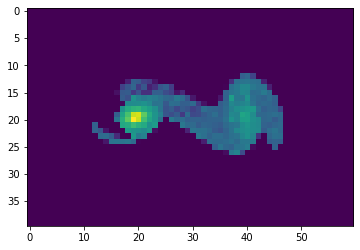

In [39]:
def grab_image_1( img_path, target_size=( 60, 40 ), normMethod = 1, printAll = False ):
    img = cv2.imread( img_path, 0 )
    img = cv2.resize( img, target_size )
    img = img.astype('float')
    

    img = img / 255.0
    
    if printAll:
        print(img.shape)
        print(img[0,0], img[20,20])
        plt.imshow( img )
    
    img = img.flatten()
    img = np.expand_dims(img, axis=0)
    x = preprocess_input(img)
    return x

def get_training_images( n = 10, normMethod = 1, target_size = (60,40), printAll = False ):    
    
    X = np.concatenate([grab_image_1('/home/dmr3p/Demo/Demo/Demo/miscImgs/%s_model.png' % (str(i).zfill(4)) , normMethod=1, target_size=target_size, printAll = printAll) for i in range(n)])
    return X

t = get_training_images( n = 1, normMethod=1, printAll = True )
print(t.shape)

Description of what the function does and what we use it for 

In [40]:
def get_human_scores( n=0, csvLoc = '/home/dmr3p/Demo/Demo/Demo/miscImgs/scores/humanScores.txt' ):
    
    hScores = pd.read_csv( csvLoc, header=None )
    
    Y = hScores[0].values
    #Y = np.expand_dims(Y, axis=0)

    
    if n == 0:
        return Y
    else:
        return Y[:n]


print( get_human_scores(  ) )
print( get_human_scores(  n = 2 ) )

[0.945946 0.941176 0.918919 ... 0.       0.       0.      ]
[0.945946 0.941176]


In [46]:
n = 100  #couldn't get 500 to work, only 100
input_size = ( 60, 40 )

X = get_training_images( n=n, normMethod=1, target_size = input_size, printAll = False )
print(X.shape)

Y = get_human_scores( n )
print(Y.shape)

model = slr_1( X.shape )
model.summary()

(100, 2400)
(100,)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 2401      
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________


In [47]:
# single layer regression model
def slr_1( input_shape, printAll = False, drop=None ):
    
    if printAll:
        print(input_shape)
        print(input_shape[1])
    
    model = keras.Sequential()
    
    model.add( keras.layers.Dense( 1,
        activation='sigmoid',
        input_shape=[input_shape[1]] ) )
    
    if drop != None:
        model.add(keras.layers.Dropout(drop))
    
    model.compile(loss=keras.losses.mean_squared_error,
        optimizer=keras.optimizers.RMSprop(0.001),
        metrics=['mse'] )
    
    # model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

modelt = slr_1( X.shape, printAll = True )
modelt.summary()

(100, 2400)
2400
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 2401      
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________


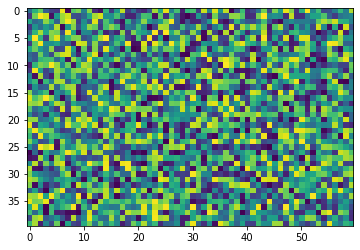

In [48]:
def view_weights( model, saveLoc = None ):

    weights = model.get_weights()[0]
    l1 = weights[:,0]
    l1 = np.reshape( l1, input_size[::-1] )

    plt.imshow(l1)
    plt.show()
    
    if saveLoc != None:
        plt.savefig( saveLoc )
    
view_weights(model)

Description of what the function does and what we use it for 

Done~


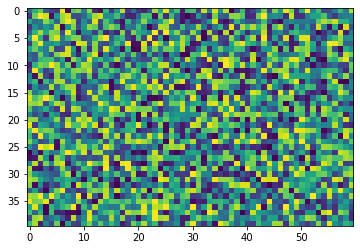

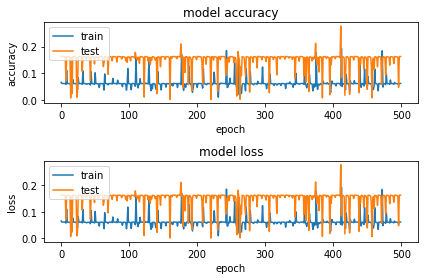

In [49]:
batch_size = 25
epochs = 500
history = model.fit(X, Y,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    validation_split = 0.2)

print('Done~')
view_weights(model)
view_mse(history)

In [ ]:
i = 0
from IPython.display import clear_output

#while :
#    batch_size = 25
 #   epochs = 100
  #  history = model.fit(X, Y,
  #      batch_size=batch_size,
  #      epochs=epochs,
  #      verbose=0,
  #      validation_split = 0.2)
  #  
  #  clear_output(wait=False)
  #  print(i)
    #view_mse(history)
   # view_weights(model, saveLoc='1.png')

In [ ]:
n2 = 500
input_size = ( 60, 40 )

X2 = get_training_images( n=n2, target_size = input_size, normMethod=1, printAll = False )
print(X2.shape)

Y2 = get_human_scores( n2 )
print(Y2.shape)

model2 = slr_1( X2.shape )
model2.summary()

i2 = 0

view_weights(model2, saveLoc='2.png')

from IPython.display import clear_output

In [ ]:
history2 = model2.fit(X, Y,
    batch_size=5,
    epochs=100,
    verbose=0,
    validation_split = 0.2)


if True:
    t_mse = history2.history['mse']
    v_mse = history2.history['val_mse']

batch_size = 25
epochs = 250

while True:
    
    history2 = model2.fit(X, Y,
        batch_size=batch_size,
        epochs=epochs,
        verbose=0,
        validation_split = 0.2)
    
    t_mse = np.append( t_mse, history2.history['mse'] )
    v_mse = np.append( v_mse, history2.history['val_mse'] )

    i2 += 1
    
    clear_output(wait=False)
    print(i2)
    view_weights(model2, saveLoc='2.png')
    #view_mse(history2)

In [ ]:
def view_mse_2( history=None, t_mse=None, v_mse=None ):
    
    if history == None and t_mse=None and v_mse=None:
        print("BAD")
        return
    
    if t_mse == None:
        
    
    plt.figure(1)
    # summarize history for accuracy
    plt.subplot(211)
    
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.tight_layout()

In [12]:
view_weights(model2, saveLoc='2.png')

# serialize model to JSON
model_json = model2.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model2.save_weights("model2.h5")
print("Saved model to disk")

NameError: name 'model2' is not defined

In [14]:
n = 500
human_scores = get_human_scores( n=500)
imgs2 = get_training_images( n=n, target_size = input_size, printAll = False )

view_weights(model2, saveLoc='2.png')

print(imgs2.shape)

print( imgs2[0,:].shape)
#print( imgs2[0,:] )
#plt.imshow(imgs[0])

#machine_scores = model2.predict( imgs2[:,:] )
#machine_scores = model2.predict( X2 )

#print(machine_scores[0:10])
#print(Y2)
    
plt.scatter( Y2, machine_scores)

NameError: name 'pd' is not defined